In [1]:
import csv
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
# results become repeatable
np.random.seed(0)

In [3]:
windows_machine = 0 # flag to identify if training data was generated using windows machine

# Read the lines from csv files
lines = []

with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        lines.append(line)

# collect the center images and corresponding steering measurements
center_images = []
steering_meas = []
for line in lines:
    source_path = line[0]
    if windows_machine:
        filename = source_path.split('\\')[-1]
    else:
        filename = source_path.split('/')[-1]  
        
    current_path = './data/IMG/' + filename
    
    # add center camera images
    image = cv2.imread(current_path)
    # cv2 reads image as bgr, convert to rgb
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    center_images.append(image)
    # add steering measurements
    measurement = float(line[3])
    steering_meas.append(measurement)

./data/IMG/center_2017_06_15_08_32_09_277.jpg


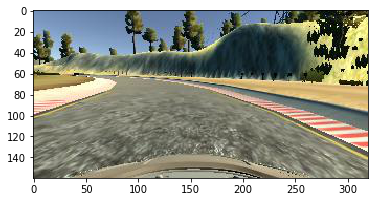

In [4]:
print(current_path)
plt.figure()
plt.imshow(center_images[0])
plt.show()

In [5]:
# Split the test and train set (10% in test set)
X_train, X_test, y_train, y_test = train_test_split(center_images, steering_meas,test_size = 0.10, random_state = 100)

In [6]:
# based on center images, find the left/stright/right turn images (this will help in figuring out the distribution)
# Left->Right turn is positive steering and Right->Left turn is negative steering
im_straight, im_left, im_right = [], [], []
steer_straight, steer_left, steer_right = [], [], []

for i in range(len(y_train)):
    if y_train[i] > 0.15: # right turn, append images to im_right
        im_right.append(X_train[i])
        steer_right.append(y_train[i])
    if y_train[i] < -0.15: # left turn, append images to im_left
        im_left.append(X_train[i])
        steer_left.append(y_train[i])
    else:
        if np.random.random() < 0.7:
            im_straight.append(X_train[i])
            steer_straight.append(y_train[i])
        

In [7]:
# free some memory
del X_train, y_train

In [8]:
# find the sample difference b/w left/stright/right images
num_left, num_right, num_straight = len(im_left), len(im_right), len(im_straight)

In [9]:
(num_left, num_right, num_straight)

(2482, 744, 11793)

In [10]:
# driving straight has the maximum images, so balance the dataset by generating more images
steering_adj = 0.1
left_xtra = num_straight - num_left
right_xtra = num_straight -num_right

# generate addtional left images
for i in range(left_xtra):
    # randomly select an image from right list
    ind = np.random.randint(0,len(im_right))
    im_left.append(im_right[ind])
    steer_left.append(steer_right[ind] - steering_adj)
    
# generate additional right images
for i in range(right_xtra):
    # randomly select an image from right list
    ind = np.random.randint(0,len(im_left))
    im_right.append(im_left[ind])
    steer_right.append(steer_left[ind] + steering_adj)
    

In [11]:
num_left, num_right, num_straight = len(im_left), len(im_right), len(im_straight)
(num_left, num_right, num_straight)

(11793, 11793, 11793)

In [12]:
# merge the left, right and straight training sets after balancing
X_train_balanced = im_left + im_right + im_straight
y_train_balanced = np.float32(steer_left + steer_right + steer_straight)

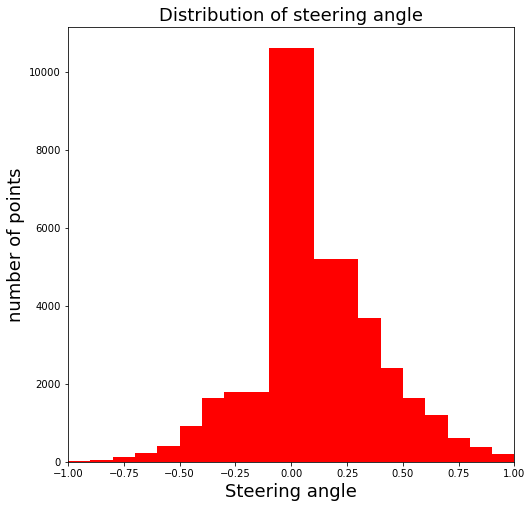

In [13]:
# plot the histogram of balanced dataset
numbins = 20
dist, bin_edges = np.histogram(y_train_balanced, numbins)
plt.figure(figsize=(8,8))
plt.bar(bin_edges[:-1], dist, color='r', width=0.2)
plt.xlabel('Steering angle', fontsize=18)
plt.ylabel('number of points', fontsize=18)
plt.xlim(min(bin_edges), max(bin_edges))
plt.title("Distribution of steering angle", fontsize=18)
plt.show()

In [14]:
# Augmentation related functions
# crop camera image to fit nvidia model input shape
def crop_camera(img):
        
    return img[60:140, 10:310, :]

def resize(image,IMAGE_WIDTH=200,IMAGE_HEIGHT=66):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

def choose_image(left_img, center_img, right_img, steering_angle, correction):
    p = np.random.choice(3)
    if p==0:
        return left_img, steering_angle + correction
    elif p==1:
        return center_img, steering_angle
    return right_img, steering_angle - correction

# brightness augmentation
def brightness_aug(image):
    
    # convert to HSV
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    # randomly set the brightness parameter
    random_bright =  np.random.uniform(0.25,1) 
    # change the V channel
    image1[:,:,2] = image1[:,:,2]*random_bright
    # convert back to RGB
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1
    
    

# horizontal and vertical shifts
def trans_image(image,steer,trans_rangeX=100,trans_rangeY=10):
    valPixels = 0.4#0.2 #0.002 #0.05/25
    rows, cols, _ = image.shape
    # Translation
    tr_x = trans_rangeX*np.random.uniform()-trans_rangeX/2
    steer_ang = steer + tr_x/trans_rangeX *2* valPixels
    tr_y = trans_rangeY*np.random.uniform()-trans_rangeY/2
    
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

def jitter_angle(angle):
    #new_angle = angle * (1.0 + np.random.uniform(-1, 1)/25.0)
    new_angle = np.random.normal(angle, 0.2)
    return new_angle

def random_flip(img,angle):
    toss = np.random.random()
    if toss <= 0.5:
        img = cv2.flip(img,1)
        angle = -angle
      
    return img, angle    

def random_shadow(image, IMAGE_WIDTH=320, IMAGE_HEIGHT=160):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

def rgb2yuv(image):
     """
     Convert the image from RGB to YUV (This is what the NVIDIA model does)
     """
     return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

def rgb2hls(image):
     """
     Convert the image from RGB to YUV (This is what the NVIDIA model does)
     """
     return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
     
def rgb2hsv(image):
     """
     Convert the image from RGB to YUV (This is what the NVIDIA model does)
     """
     return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

def rgb2gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

'''
def augument(center_img, left_img, right_img, steering_angle, correction=0.25, range_x=100, range_y=20):
    #img, steer_ang = choose_image(left_img, center_img, right_img, steering_angle, correction)
    img, steer_ang = random_flip(img, steer_ang)
    #img, steer_ang = trans_image(img, steer_ang, range_x, range_y)
    img = random_shadow(img)
    img = brightness_aug(img)
    return img, steer_ang
'''


def augument(img, steer_ang):
    img, steer_ang = random_flip(img, steer_ang)
    img = random_shadow(img)
    img = brightness_aug(img)
    return img, steer_ang

def process_image(img):
    #print("Inside process image...")
    img = crop_camera(img)
    img = resize(img,IMAGE_WIDTH=96,IMAGE_HEIGHT=64)
    #img = rgb2yuv(img)
    #img = rgb2hls(img)
    #img = rgb2hls(img)
    return img

original steering-0.20000000298023224


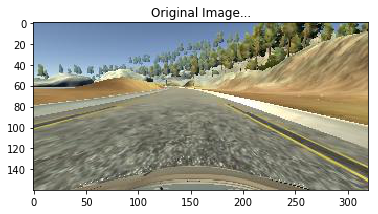

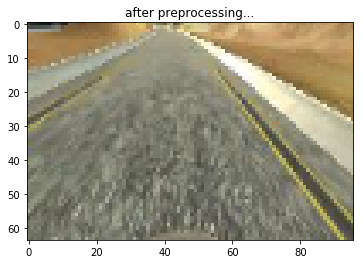

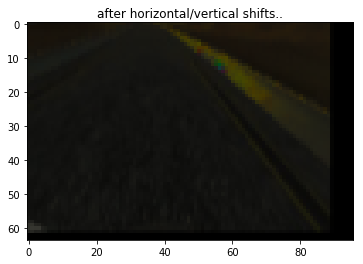

Steering: -0.38207921121413224


In [15]:
image = X_train_balanced[0]
steer = y_train_balanced[0]
print("original steering{}".format(steer))
plt.figure()
plt.imshow(image)
plt.title("Original Image...")
plt.show()
img = process_image(image)
plt.figure()
plt.imshow(img)
plt.title("after preprocessing...")
plt.show()
img = random_shadow(img, IMAGE_WIDTH=96, IMAGE_HEIGHT=64)
img = brightness_aug(img)
img,steer = trans_image(img,steer,trans_rangeX=30,trans_rangeY=10)
plt.figure()
plt.imshow(img)
plt.title("after horizontal/vertical shifts..")
plt.show()
print("Steering: {}".format(steer))

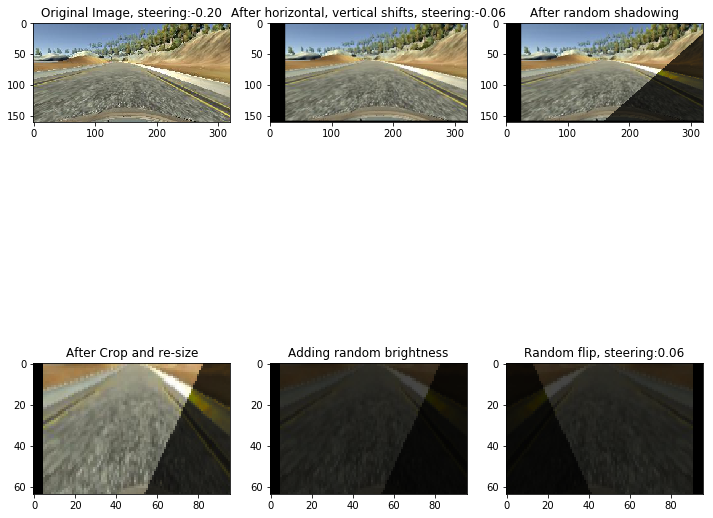

In [30]:
image = X_train_balanced[0]
steer_orig = y_train_balanced[0]

# horizontal and vertical translation
img1,steer = trans_image(image,steer_orig,trans_rangeX=140,trans_rangeY=80)
# random shadow
img2 = random_shadow(img1, IMAGE_WIDTH=320, IMAGE_HEIGHT=160)
# crop and re-size
img3 = process_image(img2)
# add random brightness
img4 = brightness_aug(img3)
# random flip
img5, steering = random_flip(img4,steer)
plt.figure(figsize=(12,12))
plt.subplot(2,3,1)
plt.imshow(image)
plt.title("Original Image, steering:{:0.2f}".format(steer_orig))
plt.subplot(2,3,2)
plt.imshow(img1)
plt.title("After horizontal, vertical shifts, steering:{:0.2f}".format(steer))
plt.subplot(2,3,3)
plt.imshow(img2)
plt.title("After random shadowing")
plt.subplot(2,3,4)
plt.imshow(img3)
plt.title("After Crop and re-size")
plt.subplot(2,3,5)
plt.imshow(img4)
plt.title("Adding random brightness")
plt.subplot(2,3,6)
plt.imshow(img5)
plt.title("Random flip, steering:{:0.2f}".format(steering))
plt.show()


In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, ELU, Convolution2D, Dropout, Activation, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
'''
def build_nvidia_model(img_height=64, img_width=64, img_channels=3, dropout=.1):
  input_shape = (64,64,3)
  model = Sequential()
  model.add(Lambda(lambda x: x/255 - 0.5, input_shape = input_shape))
  model.add(Convolution2D(24, 5, 5, border_mode='valid', activation='elu', subsample =(2,2), W_regularizer = l2(0.001)))
  model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='elu', subsample =(2,2), W_regularizer = l2(0.001)))
  model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='elu', subsample = (2,2), W_regularizer = l2(0.001)))
  model.add(Convolution2D(64, 3, 3, border_mode='same', activation='elu', subsample = (2,2), W_regularizer = l2(0.001)))
  model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='elu', subsample = (2,2), W_regularizer = l2(0.001)))
  model.add(Flatten())
  model.add(Dense(80, activation='elu', W_regularizer = l2(0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(40, activation='elu', W_regularizer = l2(0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(16, activation='elu', W_regularizer = l2(0.001)))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='elu', W_regularizer = l2(0.001)))
  #model.add(Dense(1, activation='elu', W_regularizer = l2(0.001)))
  model.add(Dense(1))
  model.summary()
  adam = Adam(lr = 0.0001)
  model.compile(optimizer= adam, loss='mse', metrics=['accuracy'])
  return model
'''

In [16]:
def build_nvidia_model(img_height=64, img_width=96, img_channels=3, dropout=.5):
    size1 = img_height
    size2 = img_width
    model = Sequential()
    #0. Model chooses how to convert Color channels 
    model.add(Convolution2D(1,1,1, border_mode = 'same',init ='glorot_uniform',input_shape=(size1,size2,3))) 
    
    #1. Convolutional, kernel(5,5) - Output 24 
    model.add(Convolution2D(24,3,3, border_mode = 'valid',init ='glorot_uniform', W_regularizer=l2(0.01))) 
    model.add(Activation('elu')) 
    model.add(MaxPooling2D((2, 2), border_mode='valid')) 
    #2. Convolutional, kernel(5,5) - Output 36 
    model.add(Convolution2D(36, 3,3, border_mode = 'valid',init ='glorot_uniform')) 
    model.add(Activation('elu')) 
    model.add(MaxPooling2D((2, 2), border_mode='valid')) 
    #3. Convolutional, kernel(5,5) - Output 48 
    model.add(Convolution2D(48, 3,3, border_mode = 'valid',init ='glorot_uniform')) 
    model.add(Activation('elu')) 
    model.add(MaxPooling2D((2, 2), border_mode='valid')) 
    #4. Flatten 
    model.add(Flatten()) 
    #5. Dense 100 
    model.add(Dropout(.5)) 
    model.add(Dense(100,init='uniform')) 
    model.add(Activation('elu')) 
    #6. Dense 100
    model.add(Dense(100,init='uniform')) 
    model.add(Activation('elu')) 
    #7. Dense 10 
    model.add(Dense(10,init='uniform')) 
    model.add(Activation('elu')) 
    #8. Output 
    model.add(Dense(1)) 
    model.summary()
    model.load_weights("./model09.h102")
    adam = Adam(lr = 0.0001)
    model.compile(optimizer= adam, loss='mse', metrics=['accuracy']) 
    
    return model


In [54]:
def generator_data(X_train_balanced, y_train_balanced, batch_size):
    batch_train = np.zeros((batch_size, 64, 96, 3), dtype = np.float32)
    batch_angle = np.zeros((batch_size,), dtype = np.float32)
    while True:
        data, angle = shuffle(X_train_balanced, y_train_balanced)
        for i in range(batch_size):
            #print("Train generator...")
            choice = int(np.random.choice(len(data),1))
            # Augment : flip, random shadow, random brightness
            #img, steering =  augument(data[choice], angle[choice])
            
            img = data[choice]
            steer = angle[choice]
            
            # do horizontal/vertical translation
            p = np.random.random()
            if p<0.5:
                # horizontal and vertical translation
                img,steer = trans_image(img,steer,trans_rangeX=140,trans_rangeY=80)
                # random shadow
                img = random_shadow(img, IMAGE_WIDTH=320, IMAGE_HEIGHT=160)
            
            # crop and re-size
            img = process_image(img)
            # add random brightness
            img = brightness_aug(img)
                        
            # random flip
            img, steering = random_flip(img,steer)
          
            batch_train[i] = img
            batch_angle[i] = steering*(1+ np.random.uniform(-0.1,0.1))
          

        yield batch_train, batch_angle

In [55]:
def generator_valid(X_test, y_test, batch_size):
    batch_train = np.zeros((batch_size, 64, 96, 3), dtype = np.float32)
    batch_angle = np.zeros((batch_size,), dtype = np.float32)
    while True:
        data, angle = shuffle(X_test, y_test)
        for i in range(batch_size):
            #print("Inside Valid generator...")
            choice = int(np.random.choice(len(data),1))
            #print(choice)
            # crop and re-size
          
            img = process_image(data[choice])
            batch_train[i] = img
            batch_angle[i] = angle[choice]
          

        yield batch_train, batch_angle

In [56]:
# train the model
train_generator = generator_data(X_train_balanced, y_train_balanced, batch_size=128) 
validation_generator = generator_valid(X_test, y_test, batch_size=128)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_25 (Convolution2D) (None, 64, 96, 1)     4           convolution2d_input_7[0][0]      
____________________________________________________________________________________________________
convolution2d_26 (Convolution2D) (None, 62, 94, 24)    240         convolution2d_25[0][0]           
____________________________________________________________________________________________________
activation_37 (Activation)       (None, 62, 94, 24)    0           convolution2d_26[0][0]           
____________________________________________________________________________________________________
maxpooling2d_19 (MaxPooling2D)   (None, 31, 47, 24)    0           activation_37[0][0]              
___________________________________________________________________________________________

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


35456/35379 [==============================] - 63s - loss: 0.0632 - acc: 0.1399 - val_loss: 0.0239 - val_acc: 0.7518
Epoch 2/10
35456/35379 [==============================] - 63s - loss: 0.0566 - acc: 0.1416 - val_loss: 0.0246 - val_acc: 0.7256
Epoch 3/10
35456/35379 [==============================] - 62s - loss: 0.0514 - acc: 0.1449 - val_loss: 0.0243 - val_acc: 0.7477
Epoch 4/10
35456/35379 [==============================] - 63s - loss: 0.0489 - acc: 0.1440 - val_loss: 0.0245 - val_acc: 0.7348
Epoch 5/10
35456/35379 [==============================] - 63s - loss: 0.0464 - acc: 0.1392 - val_loss: 0.0258 - val_acc: 0.7348
Epoch 6/10
35456/35379 [==============================] - 62s - loss: 0.0460 - acc: 0.1380 - val_loss: 0.0249 - val_acc: 0.7302
Epoch 7/10
35456/35379 [==============================] - 63s - loss: 0.0444 - acc: 0.1407 - val_loss: 0.0256 - val_acc: 0.7344
Epoch 8/10
35456/35379 [==============================] - 62s - loss: 0.0428 - acc: 0.1398 - val_loss: 0.0249 - val

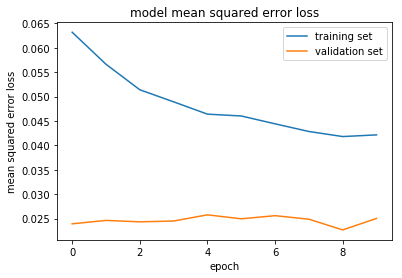

In [57]:
model = build_nvidia_model()
checkpoint = ModelCheckpoint('model{epoch:02d}.h104')
history_object = model.fit_generator(train_generator, samples_per_epoch= 1*len(X_train_balanced), validation_data=validation_generator, nb_val_samples=1*len(X_test), nb_epoch=10, callbacks=[checkpoint])
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
len(X_train_balanced)

In [ ]:
print(X_train_balanced[0])